<a href="https://colab.research.google.com/github/sen-28/Vision-Transformers/blob/main/NNFL_Final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive and Switching Directories

In [ ]:
cd /content/drive/MyDrive/ViT_NNFL_dataset/

/content/drive/MyDrive/ViT_NNFL_dataset


Importing Required Libraries


*   math : mathematical function by C standard
*   matplotlib : Visualising plots and images
*   numpy : mathematical operations
*   os : Library to use operating system dependent functionalities
* pandas : data analysis and manipulation tool
* PIL :  Python Imaging Library adds image processing capabilities to your Python interpreter
* sklearn : machine learning library built on top of SciPy
* time : used to calculate numbers of seconds elapsed since epoch
* tqdm : visualising progress bars while training
* torch modules : used for operating on tensors
* json : Python module used to work with JSON data



In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import time
from tqdm.notebook import tqdm
import json
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchvision.utils import make_grid

Flattening 2D patches of fixed size


> Initialisation of the class
 * Using nn.Conv2d to get the linear embedding of each patch
 * The stride and kernel size are equal to the patch size 
 * Instead of flattening each patch and multiplying with a matrix using the conv2d module we are able to accelerate this operation
 * since the embedding dimension is 768, we have 768 filters for the same

> Forward module
* After running the convolution operation we get a 2d output
* We use the flatten operation to make it 1d 
* The transpose operation is used to exchange the rows and columns





In [ ]:
class ImgPatches(nn.Module):
    def __init__(self, in_ch=3, embed_dim=768, patch_size=16):
        super().__init__()
        self.patch_embed = nn.Conv2d(in_ch, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)

    def forward(self, img):
        patches = self.patch_embed(img).flatten(2).transpose(1, 2)
        return patches

Multi Layered Perceptron
* Fully Connected Layer
* Gelu Activation : Gaussian Error Linear Unit
𝑥Φ(𝑥) , Φ(𝑥) = 𝐏(𝑋 ≤ 𝑥) and 𝑋 ~ 𝒩(0,1)
> * Activations like ReLU, ELU and PReLU have enabled faster and better convergence of Neural Networks than sigmoids
> * Dropout regularizes the model by randomly multiplying a few activations by 0
> * Gelu combined both
* Fully Connected Layer
* Dropout 
> * Regularization technique used in neural networks, increases generalisation capabilites of a deep learning model by learning a sparse representation

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None,
                 dropout=0.):
        super().__init__()
        if not hidden_features:
            hidden_features = in_features
        if not out_features:
            out_features = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.actn = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.actn(x)
        x = self.fc2(x)
        return self.dropout(x)


Attention Module
* b : Number of images in a batch
* n : Number of patches per image
* c : Number of channels

* qkv : query, keys and values (3 times the dimension size) obtained by Fully connected Linear layer

* dot : dot product of queries of each patch with the key of all other patches 

* Attention : calculated by using softmax over dot

* x : calculate the importance of each patch in the sequence by multiplying the values of patch with the attention matrix

* Finally pass out through a linear layer with dropout for faster convergence


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attn_dropout=0., proj_dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        self.scale = 1./dim**0.5

        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(proj_dropout)
        )

    def forward(self, x):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c//self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        dot = (q @ k.transpose(-2, -1)) * self.scale
        attn = dot.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.out(x)
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Block
* Layer Norm
* Attention 
* Layer Norm
* MultiLayered Perceptron

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, drop_rate, drop_rate)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, dim*mlp_ratio, dropout=drop_rate)

    def forward(self, x):
        x1 = self.ln1(x)
        x = x + self.attn(x1)
        x2 = self.ln2(x)
        x = x + self.mlp(x2)
        return x

The Transformer Module

In [ ]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

The Vision Transformers Module
* Checks if the dimensions of the image to create patches
* Calculates number of patches
* Creates patches and embeddings for the same
* Initialises weights and position and class embeddings 
* Add the positional embedding
* Adding dropout
* Passes the embeddings through the transformer 
* Normalisation Layer
* Output

In [ ]:
class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
                 drop_rate=0.):
        super().__init__()
        if img_size % patch_size != 0:
            raise ValueError('Image size must be divisible by patch size.')
        num_patches = (img_size//patch_size) ** 2
        self.patch_size = patch_size

        # Image patches and embedding layer
        self.patches = ImgPatches(in_ch, embed_dim, self.patch_size)

        # Embedding for patch position and class
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        self.cls_emb = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.pos_emb, std=0.2)
        nn.init.trunc_normal_(self.cls_emb, std=0.2)

        self.drop = nn.Dropout(p=drop_rate)
        self.transfomer = Transformer(depth, embed_dim, num_heads,
                                      mlp_ratio, drop_rate)
        self.norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim, num_classes)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        b = x.shape[0]
        cls_token = self.cls_emb.expand(b, -1, -1)

        x = self.patches(x)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_emb
        x = self.drop(x)
        x = self.transfomer(x)
        x = self.norm(x)
        x = self.out(x[:, 0])
        return x

Using GPU if available

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Seed for reproducibility

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
SEED = 17
seed_everything(SEED)

Loading training and validation dataset

In [ ]:
train_dir = 'train_images'
train_csv = '/content/drive/MyDrive/ViT_NNFL_dataset/Copy of new_train - new_train.csv'
test_dir = 'test_images'
name_json = 'label_num_to_disease_map.json'

Load and display format of training dataset

In [ ]:
train_df = pd.read_csv(train_csv)
train_df.head()

,image_id,label
0,4062287710.jpg,2
1,3142222157.jpg,1
2,1287334854.jpg,0
3,2137686815.jpg,1
4,4022128079.jpg,0


Loading the Cassava Dataset
* We convert each image in RGB format
* We then apply the set of transforms defined by us
* We then return the image with the assigned label

In [ ]:
class CassavaDS(Dataset):
    def __init__(self, df, data_dir, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.data_dir = data_dir

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            image = self.transforms(img)
        return image, label

Normalisation of the data based on standard values

In [ ]:
normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Transforms for the training and validation part of the dataset
* Various data augmentation processes 
* Followed by conversion to tensor format
* And normalisation of the same

In [ ]:
train_tf = transforms.Compose([
    transforms.Pad(4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

valid_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

Splitting the dataset into training and validation

In [ ]:
X_train, X_valid = train_test_split(train_df, test_size=0.1, 
                                                    random_state=SEED,
                                                    stratify=train_df.label.values)


Defining batch size

In [ ]:
bs = 16

Loading the training and validation datasets

In [ ]:
train_ds = CassavaDS(X_train, train_dir, train_tf)
valid_ds = CassavaDS(X_valid, train_dir, valid_tf)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=bs, shuffle=True)

Category to Name dictionary loaded from name_json

In [ ]:
with open(name_json, 'r') as f:
    cat_to_name = json.load(f)
  
print(cat_to_name)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


Class to undo changes made by class Normalise
Mainly used for displaying images

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [ ]:
unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Visualising the Dataset and Images

In [ ]:
def display_img(img, label=None, unnorm_obj=None, invert=True, return_label=True):
    if unnorm_obj != None:
        img = unnorm_obj(img)

    plt.imshow(img.permute(1, 2, 0))
    
    if label != None:
        plt.title(cat_to_name[str(label)])

In [ ]:
def display_batch(batch, unnorm_obj=None):    
    imgs, labels = batch
    
    if unnorm_obj:
        unnorm_imgs = []
        for img in imgs:
            unnorm_imgs.append(unnorm_obj(img))
        imgs = unnorm_imgs
    
    ig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


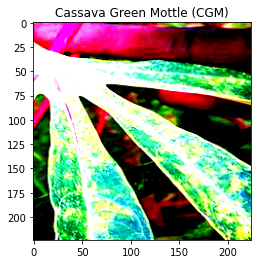

In [ ]:
img, label = train_ds[0]
display_img(img, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


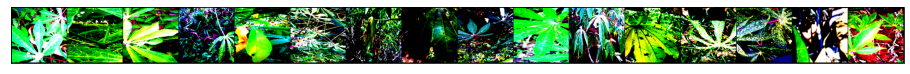

In [ ]:
display_batch(next(iter(train_loader)))

Average Statistics 
* Used to record loss
* Used to record precision

In [ ]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

Save Checkpoint : Used to store weights after a certain number of iterations so that one is able to obtain the best results and resume training from a certain stage

In [ ]:
def save_checkpoint(model, is_best, filename='./checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")

Load Checkpoints : Loading the weights stored by the save checkpoint module

In [ ]:
def load_checkpoint(model, filename = './checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)

Training function for our model.
We are using the tqdm Python library to keep track of our progress. We record accuracy and loss during training. We set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.


In [ ]:
def train(loader, model, optimizer, device):
    model.train()
    correct, trn_loss, trn_time = 0., 0., 0
    t = tqdm(loader, leave=False, total=len(loader))
    bt_start = time.time()
    for i, (ip, target) in enumerate(t):
        ip, target = ip.to(device), target.to(device)                          
        output = model(ip)
        loss = criterion(output, target)
        trn_loss += loss.item()
        
        # measure accuracy and record loss
        _, pred = output.max(dim=1)
        correct += torch.sum(pred == target.data)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    trn_time = time.time() - bt_start
    trn_acc = correct * 100 / len(loader.dataset)
    trn_loss /= len(loader)
    return trn_acc, trn_loss, trn_time

Code for validation. We turn off gradients computation during evaluation.

In [ ]:
def valid(loader, model, optimizer, device):
    model.eval()
    with torch.no_grad():
        correct, val_loss, val_time = 0., 0., 0
        t = tqdm(loader, leave=False, total=len(loader))
        bt_start = time.time()
        for i, (ip, target) in enumerate(t):
            ip, target = ip.to(device), target.to(device)                          
            output = model(ip)
            loss = criterion(output, target)
            val_loss += loss.item()

            # measure accuracy and record loss
            _, pred = output.max(dim=1)
            correct += torch.sum(pred == target.data)

        val_time = time.time() - bt_start
        val_acc = correct * 100 / len(loader.dataset)
        val_loss /= len(loader)
        return val_acc, val_loss, val_time

Appends the losses and accuracies to lists during for each epoch

In [ ]:
def fit(model, sched, optimizer, device, epoch):
    print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
    best_acc = 0.
    for j in range(epoch):
        trn_acc, trn_loss, trn_time = train(train_loader, model, optimizer, device)
        trn_stat.append(trn_loss, trn_acc, trn_time)
        val_acc, val_loss, val_time = valid(valid_loader, model, optimizer, device)
        val_stat.append(val_acc, val_loss, val_time)
        if sched:
            sched.step()
        if val_acc > best_acc:
            best_acc = val_acc
            save_checkpoint(model, True, './best_model.pth')
        print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
              .format(j+1, trn_loss, val_loss, trn_acc, val_acc))

Adding a fully connected layer for down-streaming. No. of classes is 3.

In [ ]:
def get_model(out_features=3):
    model = ViT(224, 16, drop_rate=0.1)
    load_checkpoint(model, './vit_16_224_imagenet1000.pth')
    model.out = nn.Linear(in_features=model.out.in_features, out_features=3)
    for param in model.parameters():
        param.require_grad = True
    return model

Function to get pre-trained weights after fine-tuning

In [ ]:
def get_model2(out_features=3):
    model = ViT(224, 16, drop_rate=0.1)
    load_checkpoint(model, './best_model.pth')
    model.out = nn.Linear(in_features=model.out.in_features, out_features=3)
    for param in model.parameters():
        param.require_grad = True
    return model

In [ ]:
model = get_model()
model = model.to(device)
trn_stat = AvgStats()
val_stat = AvgStats()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
epochs = 10
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-3)
fit(model, sched, optimizer, device, epochs)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1	0.97265674	0.73479610	56.14814758	72.00000000


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2	0.69874495	0.75407726	70.07407379	67.33333588


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3	0.62060920	0.94109461	71.92592621	66.00000000


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

4	0.60317913	0.59507446	74.59259033	73.33333588


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

5	0.53707443	0.69457720	77.77777863	80.00000000


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

6	0.49956306	0.71627244	79.18518829	76.00000000


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7	0.46561776	0.50329652	80.29629517	82.00000000


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8	0.40819227	0.63662902	83.62963104	80.66667175


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

9	0.35415159	0.58914140	84.96295929	80.00000000


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

10	0.32609375	0.56343600	86.88888550	82.00000000


Code to display predicted label and actual label

In [ ]:
def display_results(i):
    img, label = train_ds[i]
    display_img(img, label)
    img2 = img.unsqueeze(0)
    img2 = img2.cuda()
    y = model.forward(img2)
    _, pred = y.max(dim=1)
    prediction = ""
    if(pred[0]==0):
        prediction = 'Cassava Bacterial Blight (CBB)'
    elif(pred[0]==1):
        prediction = 'Cassava Brown Streak Disease (CBSD)'
    else: 
        prediction = 'Cassava Green Mottle (CGM)'
    
    print("Predicted label is " + prediction)


Inferences

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: ignored

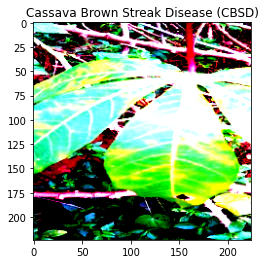

In [ ]:
display_results(5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted label is Cassava Green Mottle (CGM)


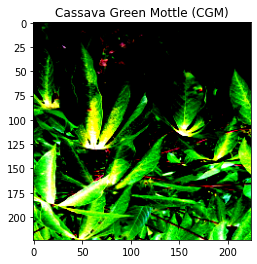

In [ ]:
display_results(100)

Plotting the losses

In [ ]:
loss_arr = trn_stat.losses
val_arr = val_stat.losses
y = [i for i in range(10)]
import matplotlib.pyplot as plt



Training loss

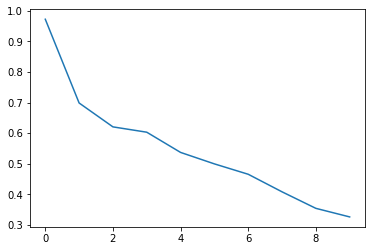

In [ ]:
plt.plot(y, loss_arr)

Validation loss

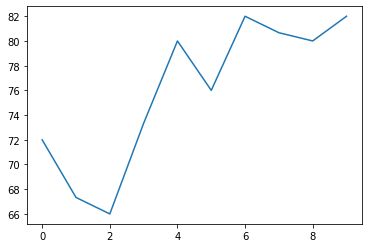

In [ ]:
plt.plot(val_arr)

In [ ]:
model2 = get_model()
model2 = model2.to(device)
load_checkpoint(model2, 'best_model.pth')

In [ ]:
def display_results2(i):
    img, label = train_ds[i]
    display_img(img, label)
    img2 = img.unsqueeze(0)
    img2 = img2.cuda()
    y = model2.forward(img2)
    _, pred = y.max(dim=1)
    print(pred)
    prediction = ""
    if(pred[0]==0):
        prediction = 'Cassava Bacterial Blight (CBB)'
    elif(pred[0]==1):
        prediction = 'Cassava Brown Streak Disease (CBSD)'
    else: 
        prediction = 'Cassava Green Mottle (CGM)'
    
    print("Predicted label is " + prediction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0], device='cuda:0')
Predicted label is Cassava Bacterial Blight (CBB)


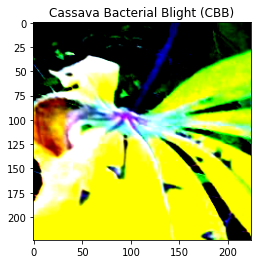

In [ ]:
display_results2(6)